# **Take Home Assignment 3**

3.0 Install any dependencies if needed


In [1]:
!pip install supervision
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [2]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import supervision as sv

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


3.1.1 Draw the segmentation mask of the largest car: Use ultralytics library only

In [3]:
img = cv2.imread("demo5_images/cars1.jpg")


0: 416x640 14 cars, 238.1ms
Speed: 4.3ms preprocess, 238.1ms inference, 55.5ms postprocess per image at shape (1, 3, 416, 640)


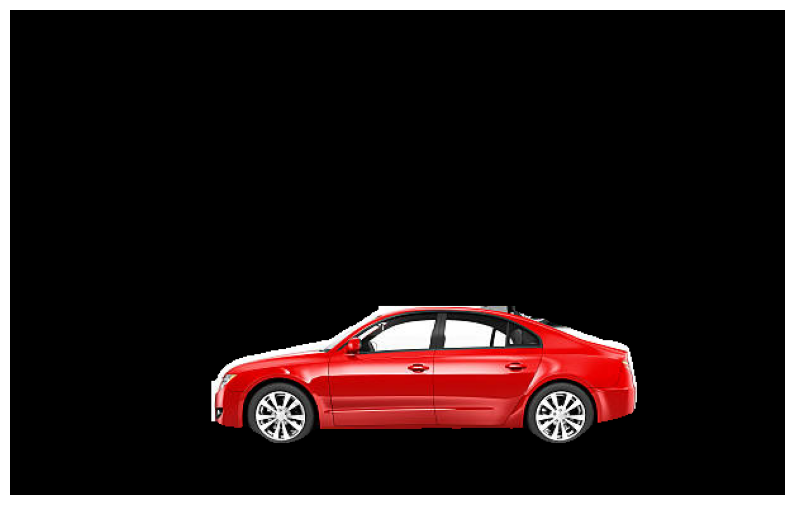

In [5]:
# Run a segmentation model on the image
model = YOLO('yolov8n-seg.pt')
results = model(img)[0]

# Iterate through the boxes in the results object
    # For each box , obtain the coordinates of the box, evaluate area
    # Find out the index of the box with the largest area

max_area = 0
largest_car_idx = None

for i, (box, cls) in enumerate(zip(results.boxes, results.boxes.cls)):
    if cls == 2:  # class ID for car
        area = (box.xyxy[0][2] - box.xyxy[0][0]) * (box.xyxy[0][3] - box.xyxy[0][1])
        if area > max_area:
            max_area = area
            largest_car_idx = i

# Draw the mask of the box with the largest area.
if largest_car_idx is not None:
    # Get the mask and resize it to match image dimensions
    mask = results.masks[largest_car_idx].data[0].cpu().numpy()
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    # Create mask with correct dimensions
    img_with_mask = img.copy()
    img_with_mask[mask < 0.5] = 0  # Using threshold of 0.5 for binary mask

        # Display the result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_with_mask, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

3.1.2 Draw the segmentation mask of the largest car : Use ultralytics + supervision libraries


0: 416x640 14 cars, 227.0ms
Speed: 5.2ms preprocess, 227.0ms inference, 43.6ms postprocess per image at shape (1, 3, 416, 640)


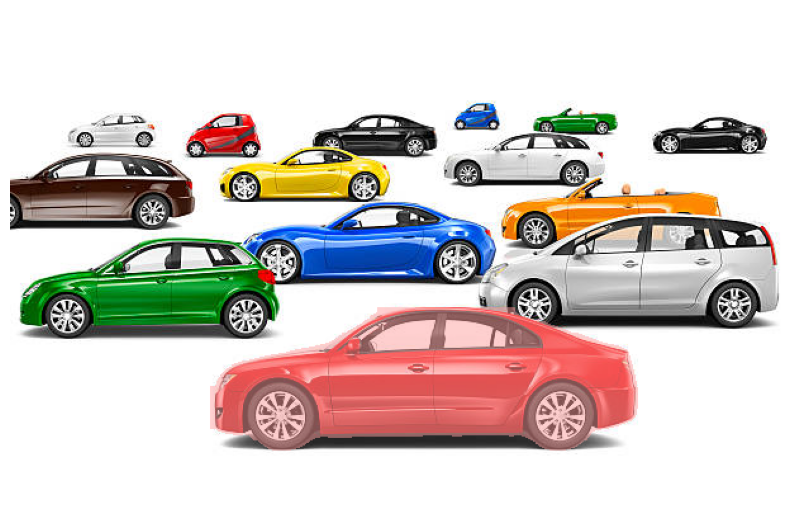

In [7]:
# Run a segmentation model on the image using ultralytics libraries & a model of your choice
model = YOLO('yolov8n-seg.pt')
results = model(img)[0]

# Transfer ultralytics results to supervision
detections = sv.Detections.from_ultralytics(results)


# Iterate through the masks & find the largest
max_area = 0
largest_mask_idx = None

for i, mask in enumerate(detections.mask):
    # Check if the detected object is a car (class_id 2 in COCO dataset)
    if detections.class_id[i] == 2:  # 2 represents car class
        area = np.sum(mask)  # Calculate mask area
        if area > max_area:
            max_area = area
            largest_mask_idx = i

# Display the largest mask

if largest_mask_idx is not None:
    # Create mask annotator
    mask_annotator = sv.MaskAnnotator()

    # Extract the largest car detection
    largest_detection = sv.Detections(
        mask=detections.mask[largest_mask_idx:largest_mask_idx+1],
        xyxy=detections.xyxy[largest_mask_idx:largest_mask_idx+1],
        class_id=detections.class_id[largest_mask_idx:largest_mask_idx+1],
        confidence=detections.confidence[largest_mask_idx:largest_mask_idx+1]
    )

    # Draw the mask on the image
    annotated_image = mask_annotator.annotate(
        scene=img.copy(),
        detections=largest_detection
    )

    # Display the result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("No cars detected in the image")

3.2 Estimate distance to centroid of chair

In [10]:
!pip install transformers
!pip install ultralytics
!pip install supervision

In [24]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from transformers import pipeline
import supervision as sv
from PIL import Image


In [20]:
# Load the first image
img1 = cv2.imread("demo5_images/kingChair.jpg")
if img1 is None:
    print("Could not load kingChair image. Please check the path and extension.")

In [21]:
# Load the second image
img2 = cv2.imread("demo5_images/chair2.jpeg")
if img2 is None:
    print("Could not load chair2 image. Please check the path and extension.")

Processing kingChair image:

0: 384x640 1 chair, 482.0ms
Speed: 4.2ms preprocess, 482.0ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


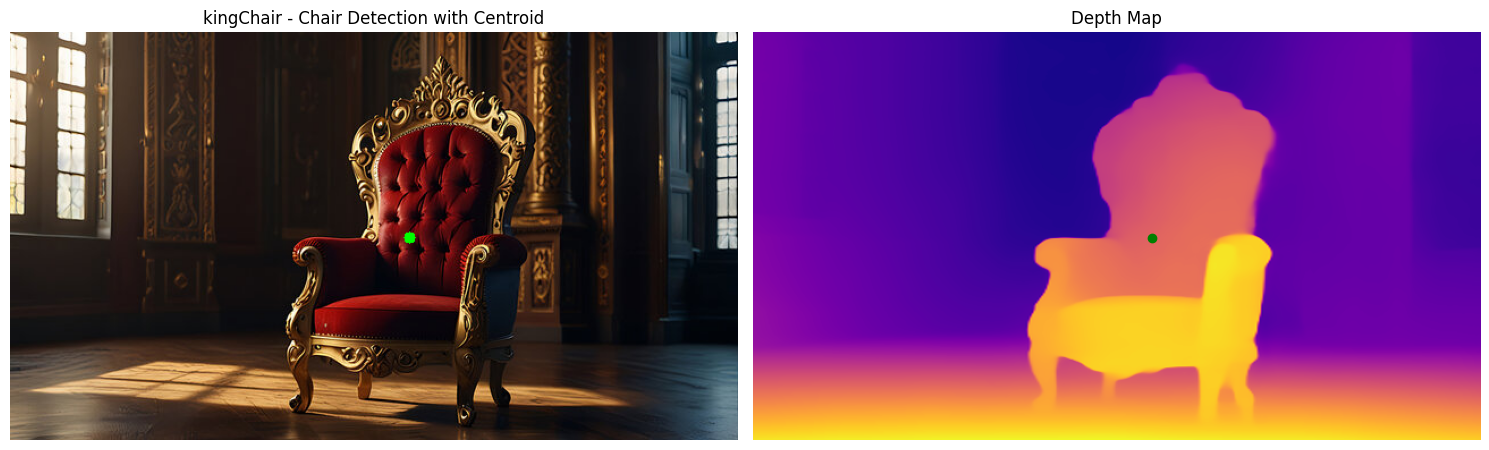

Estimated depth at chair centroid for kingChair: 20.70

Processing chair2 image:

0: 640x480 2 chairs, 312.4ms
Speed: 11.4ms preprocess, 312.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


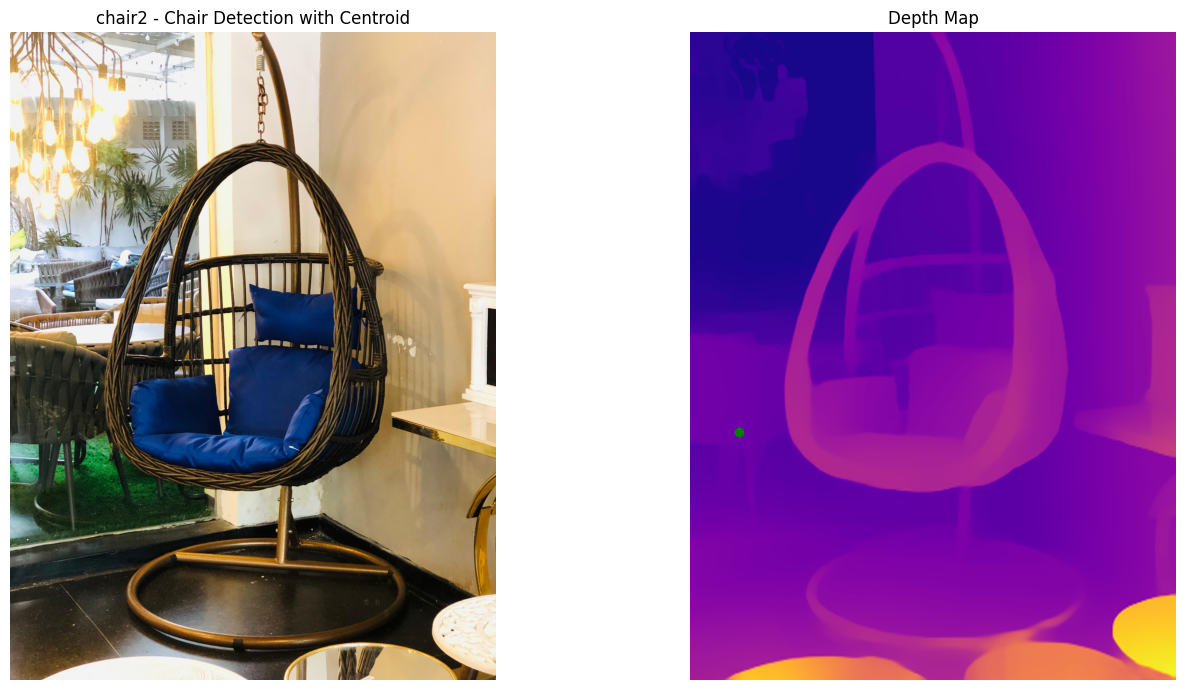

Estimated depth at chair centroid for chair2: 10.08


In [26]:
def process_chair_image(img, image_name):
    if img is None:
        print(f"Cannot process {image_name} - image not loaded correctly")
        return

    # Load YOLOv8 model
    model = YOLO('yolov8n.pt')  # Using a pre-trained detection model

    # Run object detection
    results = model(img)[0]

    # Convert results to Supervision detections
    detections = sv.Detections.from_ultralytics(results)

    # Look for chair detection (COCO class 56)
    chair_idx = None
    for i, class_id in enumerate(detections.class_id):
        if class_id == 56:  # 56 represents chair class in COCO dataset
            chair_idx = i
            break

    # If chair is detected, calculate centroid and depth
    if chair_idx is not None:
        # Get bounding box coordinates
        x1, y1, x2, y2 = map(int, detections.xyxy[chair_idx])

        # Calculate centroid
        centroid_x = int((x1 + x2) / 2)
        centroid_y = int((y1 + y2) / 2)
        chair_centroid = (centroid_x, centroid_y)

        # Load depth estimation model
        depth_estimator = pipeline("depth-estimation", model="Intel/dpt-large")  # Publicly available

        # Convert image to RGB for depth model
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert NumPy array to PIL image
        img_pil = Image.fromarray(img_rgb)

        # Get depth map
        depth_result = depth_estimator(img_pil)  # Use PIL image instead of OpenCV numpy array
        depth_map = depth_result["predicted_depth"]

        # Get depth at centroid
        depth_value = depth_map[centroid_y, centroid_x]

        # Visualize results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        # Original image with centroid
        img_with_centroid = img.copy()
        cv2.circle(img_with_centroid, chair_centroid, 5, (0, 255, 0), -1)
        ax1.imshow(cv2.cvtColor(img_with_centroid, cv2.COLOR_BGR2RGB))
        ax1.set_title(f'{image_name} - Chair Detection with Centroid')
        ax1.axis('off')

        # Convert PyTorch tensor to NumPy
        depth_map_np = depth_map.squeeze().detach().cpu().numpy()

        # Depth map visualization
        depth_vis = ((depth_map_np - depth_map_np.min()) / (depth_map_np.max() - depth_map_np.min()) * 255).astype(np.uint8)
        ax2.imshow(depth_vis, cmap='plasma')
        ax2.plot(centroid_x, centroid_y, 'go')
        ax2.set_title('Depth Map')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Estimated depth at chair centroid for {image_name}: {depth_value:.2f}")

    else:
        print(f"No chair detected in {image_name}")

# Process both images
print("Processing kingChair image:")
process_chair_image(img1, "kingChair")

print("\nProcessing chair2 image:")
process_chair_image(img2, "chair2")

3.3. Draw bounding boxes around the "cars" using supervision.

In [32]:
# Downloads the video file from the google drive link, you'll have to "pip install gdown" first
import gdown


file_id = "1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4"
direct_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(direct_url, "vehicles_video.mp4", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1zcKvnDDEdyFF4B0B3eYud6DHU19nl0o4
To: /content/vehicles_video.mp4
100%|██████████| 35.3M/35.3M [00:00<00:00, 99.8MB/s]


'vehicles_video.mp4'

3.3.1 Track the cars. Add the tracker id to the bounding boxes around the cars. Use supervision:

In [46]:
model = YOLO("yolov8n.pt")  # YOLOv8 Nano model

# Step 3: Initialize object tracker
tracker = sv.ByteTrack()

# Step 4: Define callback function to track cars and add tracker IDs
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    """
    Detects and tracks cars in a video frame. Draws bounding boxes with tracking IDs.
    """
    # Run YOLO detection
    results = model(frame)[0]

    # Ensure detections exist
    if results.boxes is None or len(results.boxes) == 0:
        return frame  # Return original frame if no detections

    # Extract bounding boxes, confidence scores, and class IDs
    boxes = results.boxes.xyxy.cpu().numpy()  # (x1, y1, x2, y2)
    confidences = results.boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = results.boxes.cls.cpu().numpy().astype(int)  # Class IDs

    # Convert to Supervision format
    if len(boxes) == 0:
        return frame  # Return unmodified frame if no valid detections

    detections = sv.Detections(xyxy=boxes, confidence=confidences, class_id=class_ids)

    # Keep only cars (verify YOLO class ID for "car")
    car_class_id = 2  # Ensure this is correct for your YOLO model
    detections = detections[detections.class_id == car_class_id]

    # Skip empty detection frames
    if len(detections) == 0:
        return frame

    # Assign tracking IDs
    tracked_detections = tracker.update_with_detections(detections)

    # Define annotators
    bounding_box_annotator = sv.BoxAnnotator(color=sv.Color.RED, thickness=2)
    label_annotator = sv.LabelAnnotator(text_color=sv.Color.WHITE, text_scale=0.5, text_thickness=1)

    # Draw bounding boxes and labels
    frame = bounding_box_annotator.annotate(scene=frame, detections=tracked_detections)
    frame = label_annotator.annotate(
        scene=frame,
        detections=tracked_detections,
        labels=[f"ID {tracker_id}" for tracker_id in tracked_detections.tracker_id]
    )

    return frame

# Step 5: Process the video and save output
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="tracked_cars.mp4",
    callback=callback
)

print(" 3.3.1 Complete! Check 'tracked_cars.mp4' for tracking results.")



0: 384x640 3 cars, 1 truck, 252.9ms
Speed: 5.0ms preprocess, 252.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 359.1ms
Speed: 4.4ms preprocess, 359.1ms inference, 10.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 917.5ms
Speed: 8.7ms preprocess, 917.5ms inference, 11.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 495.8ms
Speed: 14.6ms preprocess, 495.8ms inference, 10.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 384.9ms
Speed: 9.8ms preprocess, 384.9ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 539.5ms
Speed: 4.7ms preprocess, 539.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 541.4ms
Speed: 4.3ms preprocess, 541.4ms inference, 11.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 

3.3.2 Draw the track traces for the tracked cars. Use supervision

In [48]:
# Step 4: Define callback function to track cars and draw movement traces
def callback(frame: np.ndarray, _: int) -> np.ndarray:
    """
    Detects and tracks cars, adds tracker IDs, and draws movement traces.
    """
    # Run YOLO detection
    results = model(frame)[0]

    # Ensure detections exist
    if results.boxes is None or len(results.boxes) == 0:
        return frame  # Return original frame if no detections

    # Extract detection details
    boxes = results.boxes.xyxy.cpu().numpy()
    confidences = results.boxes.conf.cpu().numpy()
    class_ids = results.boxes.cls.cpu().numpy().astype(int)

    # Convert detections to Supervision format
    detections = sv.Detections(xyxy=boxes, confidence=confidences, class_id=class_ids)

    # Keep only cars
    car_class_id = 2  # Verify this is correct for your YOLO model
    detections = detections[detections.class_id == car_class_id]

    # Skip frames where detections are empty
    if len(detections) == 0:
        return frame

    # Assign tracking IDs
    tracked_detections = tracker.update_with_detections(detections)

    # Skip frames where tracked detections are empty
    if len(tracked_detections) == 0:
        return frame

    # Define annotators
    bounding_box_annotator = sv.BoxAnnotator(color=sv.Color.RED, thickness=2)
    label_annotator = sv.LabelAnnotator(text_color=sv.Color.WHITE, text_scale=0.5, text_thickness=1)
    trace_annotator = sv.TraceAnnotator(color=sv.Color.BLUE, thickness=2)

    # Draw bounding boxes, labels, and traces
    frame = bounding_box_annotator.annotate(scene=frame, detections=tracked_detections)
    frame = label_annotator.annotate(
        scene=frame,
        detections=tracked_detections,
        labels=[f"ID {tracker_id}" for tracker_id in tracked_detections.tracker_id]
    )
    frame = trace_annotator.annotate(scene=frame, detections=tracked_detections)

    return frame

# Step 5: Process the video and save output
sv.process_video(
    source_path="vehicles_video.mp4",
    target_path="tracked_cars_with_traces.mp4",
    callback=callback
)

print(" 3.3.2 Complete! Check 'tracked_cars_with_traces.mp4' for results with track traces.")



0: 384x640 3 cars, 1 truck, 493.2ms
Speed: 5.5ms preprocess, 493.2ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 534.8ms
Speed: 6.4ms preprocess, 534.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 346.1ms
Speed: 15.3ms preprocess, 346.1ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 bus, 1 truck, 268.2ms
Speed: 5.1ms preprocess, 268.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 258.1ms
Speed: 5.1ms preprocess, 258.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 bus, 1 truck, 279.3ms
Speed: 5.7ms preprocess, 279.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 1 truck, 293.5ms
Speed: 4.8ms preprocess, 293.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 cars, 1 truck, 290.

Questions:

The function definition def callback(frame: np.ndarray, _: int) -> np.ndarray: is a Python function signature that specifies:

    Function Name: callback
        This function is likely used as a callback, meaning it is intended to be passed as an argument and automatically executed when certain conditions are met.

    Parameters:
        frame: np.ndarray: This parameter represents an image (frame) in the form of a NumPy array. It is commonly used in image processing applications, such as video frame processing with OpenCV.
        _ : int: The underscore (_) is a conventional way of indicating that this parameter is unused. The function still expects an integer value (likely an index or a frame number), but it is not used in the function body.

    Return Type:
        -> np.ndarray: This indicates that the function returns a NumPy array, likely another image frame after processing.


This function is designed to process an image frame (frame), possibly modify it, and return the processed frame while ignoring the second parameter (_). It is commonly used in real-time video processing applications where each frame needs to be modified before being displayed or saved.